In [19]:
import gc
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, label_ranking_average_precision_score, ConfusionMatrixDisplay, confusion_matrix
from transformers import BertTokenizer, BertModel

In [20]:
df = pd.read_csv("AI-FInal-Project-main/Dataset/Re_labeled_dataset.csv")
df.head()

description  \
0  how's your sex life?by not sharing your real t...   
1  how to keep your child safe (and happy) online...   
2  ground beef recipes that go beyond burgersthin...   
3  why there are no winners in the battle of brea...   
4  the duchess of cambridge's black lace dress is...   

                                  predicted_category  
0  ['ARTS', 'DIVORCE', 'ENTERTAINMENT', 'HEALTHY ...  
1                           ['PARENTING', 'PARENTS']  
2                          ['FOOD & DRINK', 'TASTE']  
3                           ['PARENTING', 'PARENTS']  
4  ['ARTS & CULTURE', 'ENTERTAINMENT', 'MEDIA', '...

In [21]:
#找出所有分類，並重新編排，若有該分類呈現1沒有為0

In [22]:

category_list = list(sorted(set(cate for cate_list in df['predicted_category'] for cate in eval(cate_list))))
for category in category_list:
    df[category] = df['predicted_category'].apply(lambda x: 1 if category in x else 0)
df.drop(columns = ['predicted_category'], inplace = True)
df.to_csv("AI-FInal-Project-main/Dataset/Re_labeled_dataset2.csv", index=False)
df = df.sample(frac=0.5, random_state=15)
df.head()

description  ARTS  \
13648  spock was my guyspock was my guy: calm, ration...     0   
66815  isis is worse than genghis khan, says top iraq...     0   
54762  de-man cave or un-man cave? that is the questi...     1   
43756  jennifer lawrence reportedly laughs off critic...     0   
21234  selig counted money while baseball lost the ne...     0   

       ARTS & CULTURE  BLACK VOICES  BUSINESS  COLLEGE  COMEDY  CRIME  \
13648               0             0         0        1       0      0   
66815               0             0         0        0       0      0   
54762               1             1         1        1       1      1   
43756               0             1         0        0       0      0   
21234               0             0         1        0       0      0   

       CULTURE & ARTS  DIVORCE  ...  TASTE  TECH  TRAVEL  U.S. NEWS  WEDDINGS  \
13648               0        0  ...      0     0       0          0         0   
66815               0        0  ...      0     0       0          0         0   
54762               1        1  ...      1     0       1          1         1   
43756               0        0  ...      0     0       0          0         0   
21234               0        0  ...      0     0       0          0         0   

       WEIRD NEWS  WELLNESS  WOMEN  WORLD NEWS  WORLDPOST  
13648           0         0      0           0          0  
66815           0         0      0           0          1  
54762           1         1      1           1          1  
43756           0         0      0           0          0  
21234           0         0      0           0          0  

[5 rows x 42 columns]

In [23]:
# split dataset into train and test with 70% and 30%
train_df, test_df= train_test_split(df, random_state = 15, test_size = 0.3)
# drop None description
train_df = train_df[train_df['description'].notna()]
test_df = test_df[test_df['description'].notna()]


In [24]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 2
LEARNING_RATE = 3e-5
threshold = 0.5

In [25]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [26]:
# make new dataset to encode for BERT input
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer                      # set tokenizer
        self.df = df                                    # set dataframe
        self.title = df['description']                  # set title be description
        self.max_len = max_len                          # set max length
        self.targets = self.df[category_list].values    # set targets be values of dataset  
    
    def __len__(self): return len(self.title)
    
    # make index of this
    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,                                      # title to encode
            None,                                       # input do not have other text
            add_special_tokens=True,                    # the text will encoded with special token  
            max_length=self.max_len,                    # set max length
            padding='max_length',                       # padding
            return_token_type_ids=True,                 # return token model
            truncation=True,                            # fix length of title
            return_attention_mask=True,                 # return attention mask
            return_tensors='pt'                         # decide pyTorch be type of return tensor
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]) # bool value of categories in dataset[index] 
        }

In [27]:
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=15)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)
train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(valid_df, tokenizer, MAX_LEN)

In [28]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

valid_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)


In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')



In [30]:
##建置模型

In [31]:
class build_model(torch.nn.Module):
    def __init__(self):
        super(build_model, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)          # has 0.3 probablity to drop a node
        self.linear = torch.nn.Linear(768, 41)        # (768, 41) is shape of tensor
    
    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = build_model()
model.to(device)

build_model(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [32]:
# determine loss function and optimizer
loss_function = torch.nn.BCEWithLogitsLoss # Binary Cross Entropy 
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [33]:
valid_targets, valid_outputs = [], []
def train_model(n_epochs, training_loader, validation_loader, model, optimizer):
   
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf

    for epoch in range(1, n_epochs + 1):
        gc.collect()
        torch.cuda.empty_cache()                                                        # Clear GPU cache to avoid RAM comsume over
        train_loss = 0
        valid_loss = 0

        model.train()
        print('############# Epoch {}: Training Start   #############'.format(epoch))
        
        batch_idx = 1
        for data in tqdm(training_loader, desc=f"Epoch {epoch} Training"):
            batch_idx += 1
            ids = data['input_ids'].to(device, dtype=torch.long)
            mask = data['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)
            outputs = model(ids, mask, token_type_ids)

            optimizer.zero_grad()                                                       # Zero-out the gradients
            loss = loss_function()(outputs, targets)                                    # Compute the loss with BCE
            loss.backward()                                                             # Backpropagation
            optimizer.step()                                                            # Optimize the loss function

            train_loss = train_loss + ((1 / batch_idx) * (loss.item() - train_loss))    # Compute train loss by EMA

        print('############# Epoch {}: Training End     #############'.format(epoch))

        print('############# Epoch {}: Validation Start   #############'.format(epoch))
        
        model.eval()
        
        valid_targets = []
        valid_outputs = []
        with torch.no_grad():
            batch_idx = 0
            for data in tqdm(validation_loader, desc=f"Epoch {epoch} Validation"):
                batch_idx += 1
                ids = data['input_ids'].to(device, dtype=torch.long)
                mask = data['attention_mask'].to(device, dtype=torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
                targets = data['targets'].to(device, dtype=torch.float)
                outputs = model(ids, mask, token_type_ids)

                loss = loss_function()(outputs, targets)                                        # Compute the loss with BCE
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))  # Compute valid loss by EMA
                valid_targets.extend(targets.cpu().detach().numpy().tolist())                   # Copy target to valid_targets
                valid_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())    # Copy sigmoid result of output

        print('############# Epoch {}: Validation End     #############'.format(epoch))
        
        # calculate average losses
        train_loss = train_loss / len(training_loader)
        valid_loss = valid_loss / len(validation_loader)
        
        # print training/validation statistics 
        print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
        ))

        print('############# Epoch {}  Done   #############\n'.format(epoch))

    return model

In [34]:
trained_model = train_model(EPOCHS, train_data_loader, valid_data_loader, model, optimizer)


In [35]:
# model = build_model()
# model.load_state_dict(torch.load("AI-FInal-Project-main/Model/trained_model_state.pt"))
# model.to(device)
accuracy = 0
f1score = 0
lrap = 0
N = len(test_df)
all_true, all_pred = [], []                                                                      # for confusion matrix
for i in tqdm(range(N), desc=f'Test:'):
    data = test_df['description'][i]                                                             # text of test dataset
    true_label_idx = [j for j, cate in enumerate(category_list, 0) if test_df.loc[i][cate] == 1]
    true_list = set([category_list[j] for j in true_label_idx])                                  # find true result list
    encodings = tokenizer.encode_plus(
        data,                                                                                    # text of test dataset
        None,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        return_token_type_ids=True,
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    model.eval()
    with torch.no_grad():                                                                       # gradient evaluate is not need
        input_ids = encodings['input_ids'].to(device, dtype=torch.long)
        attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
        token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
        output = model(input_ids, attention_mask, token_type_ids)
        final_output = torch.sigmoid(output).cpu().detach().numpy()
        pred_label_idx = np.where(final_output[0] > threshold)[0]
        pred = train_df.columns[1:][pred_label_idx]                                             # pick categories which probablity greater than threshold
        accuracy += len(true_list.intersection(pred)) / len(true_list.union(pred))              # compute accuracy
        true_f1 = np.zeros((1, 41), dtype=int)                                                       
        pred_f1 = np.zeros((1, 41), dtype=int)
        true_f1[0, true_label_idx] = 1
        pred_f1[0, pred_label_idx] = 1
        f1score += f1_score(y_true=true_f1, y_pred=pred_f1, average='weighted')                 # compute f1-score
        lrap += label_ranking_average_precision_score(y_true=true_f1, y_score=final_output)     # compute lrap
        all_true.append(true_f1)
        all_pred.append(pred_f1)
print('accuracy {}'.format(accuracy / N))
print('f1-socre {}'.format(f1score / N))
print('LRAP {}'.format(lrap / N))

Test::   0%|          | 0/15714 [00:00<?, ?it/s]c:\Users\cheng\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\cheng\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\cheng\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_di

accuracy 0.5198664746940038
f1-socre 0.6119480769433784
LRAP 0.8174543077022698


[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 1 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]]

 [[1 1 1 ... 1 1 1]]

 [[1 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 1 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]]

 [[1 1 1 ... 1 1 1]]

 [[1 0 0 ... 0 0 0]]]


c:\Users\cheng\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


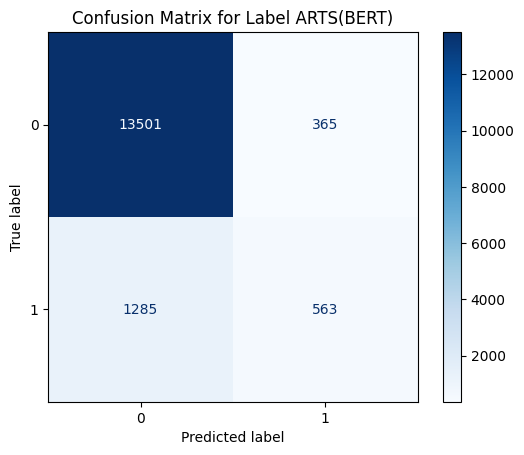

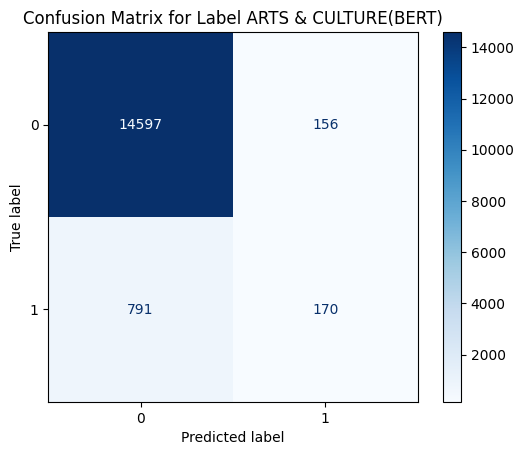

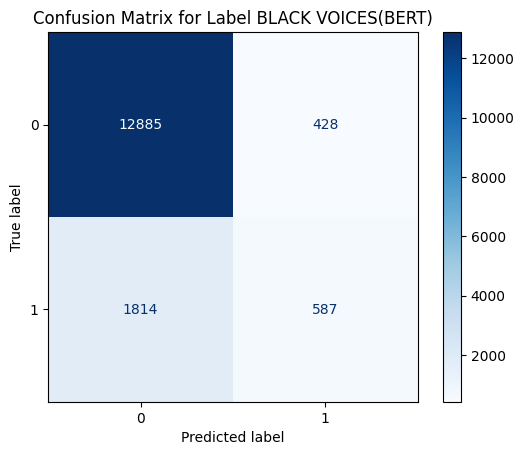

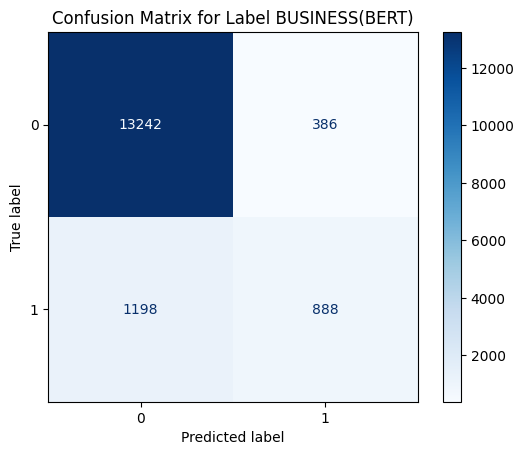

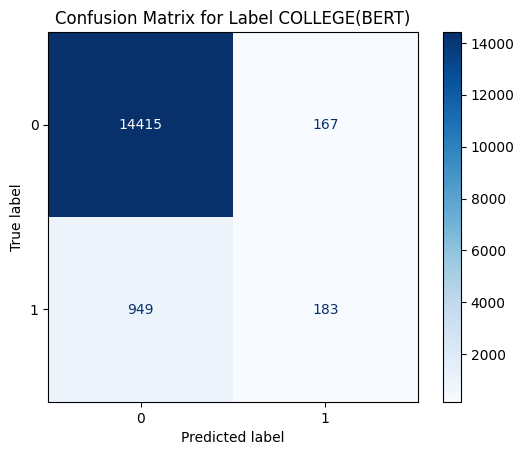

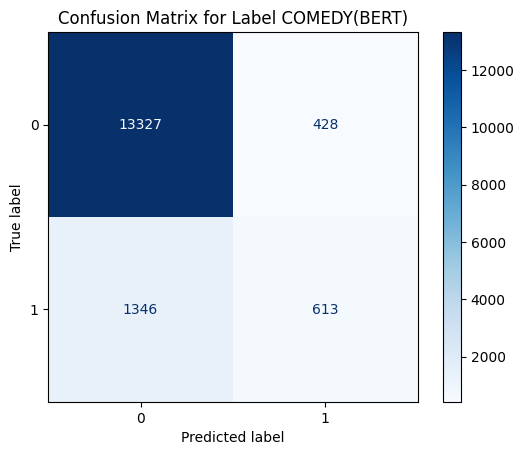

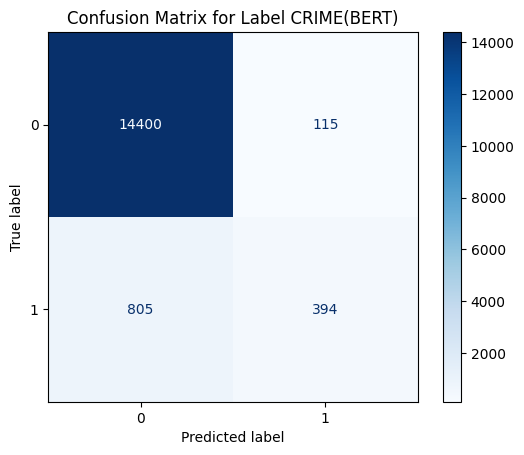

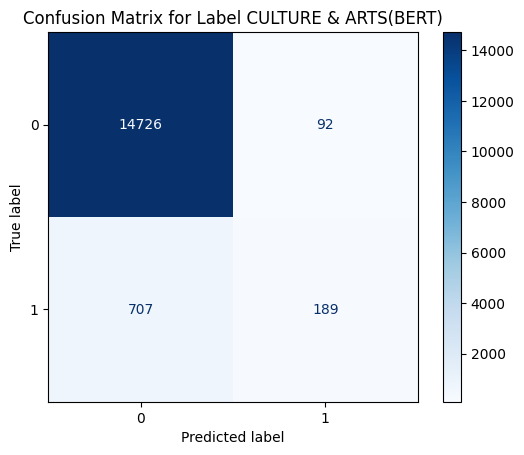

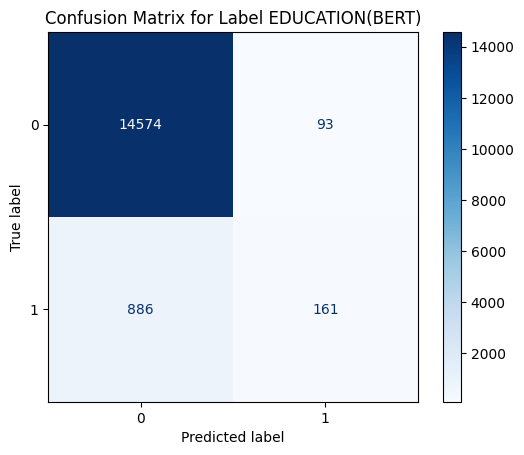

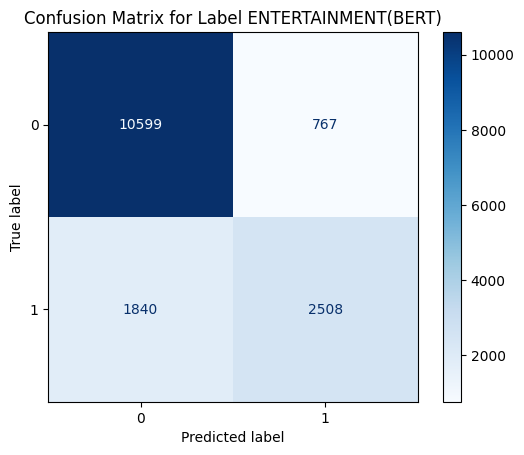

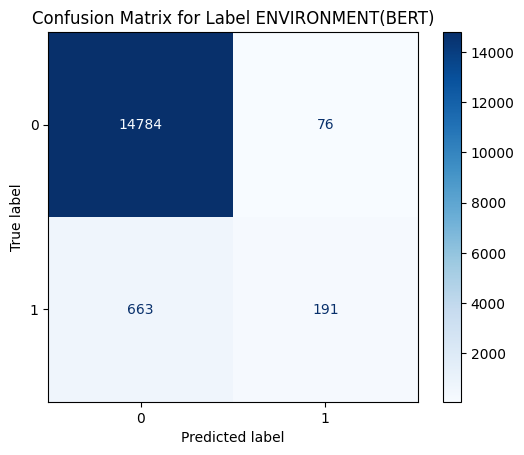

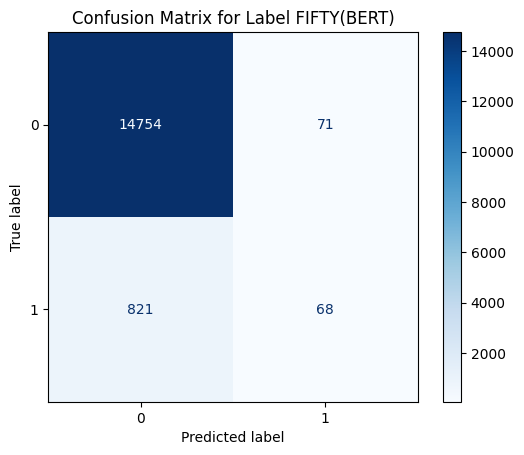

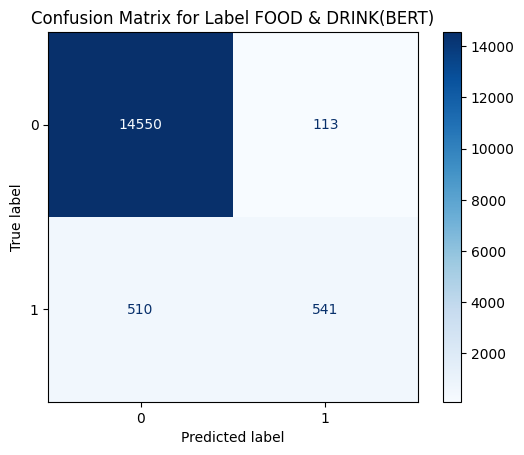

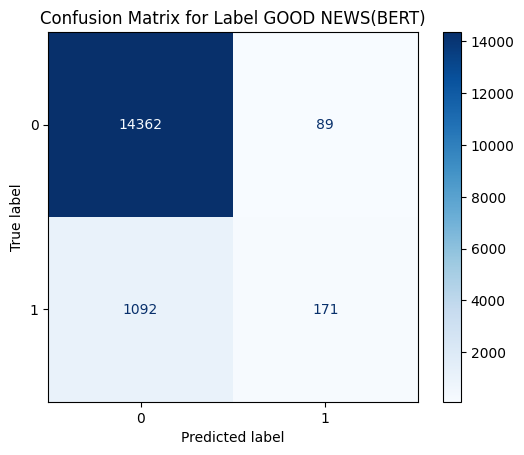

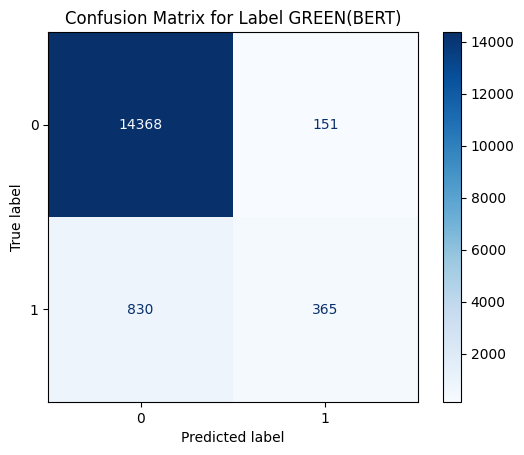

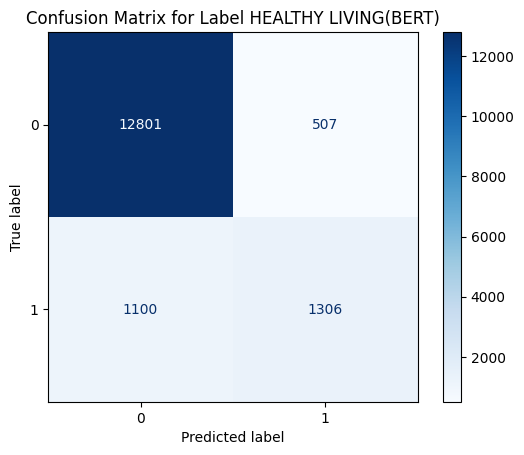

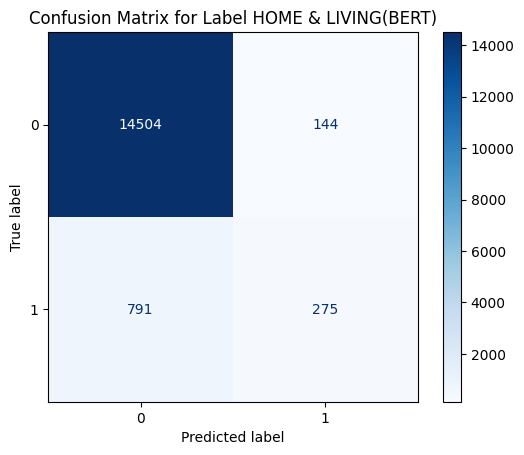

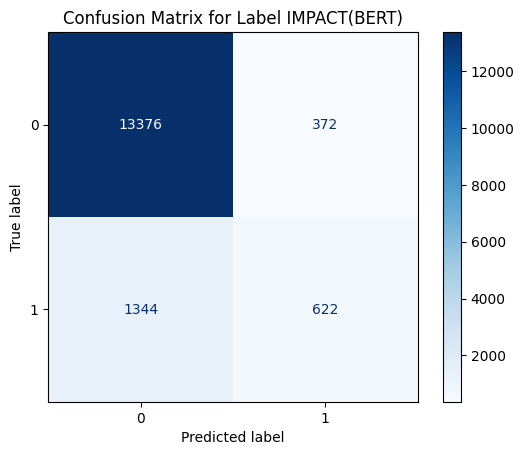

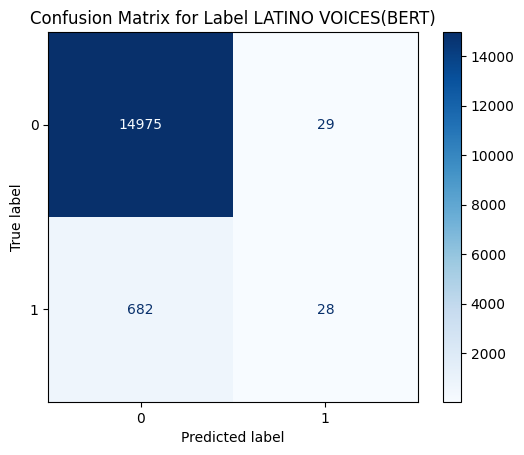

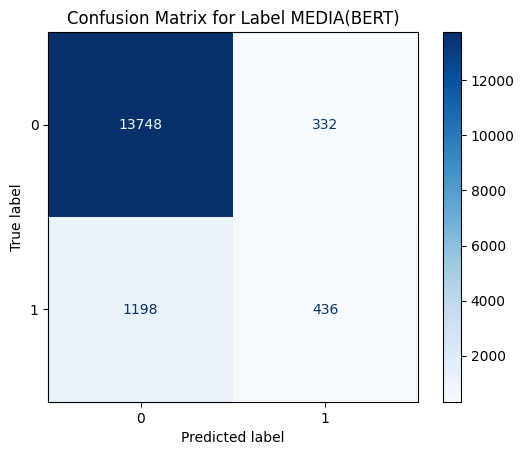

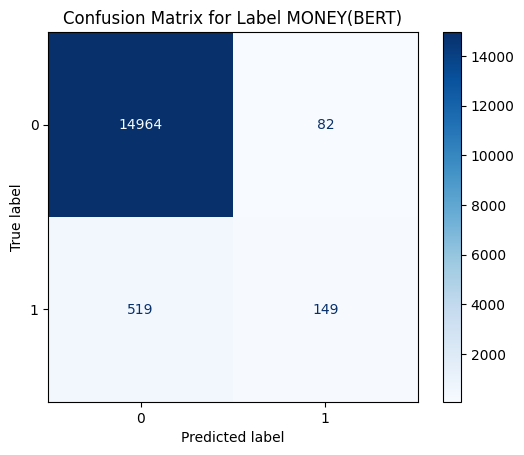

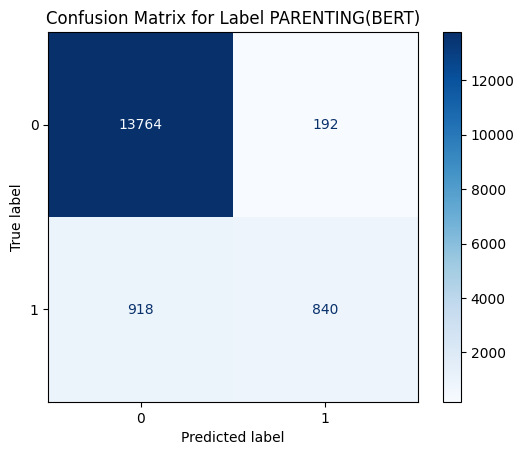

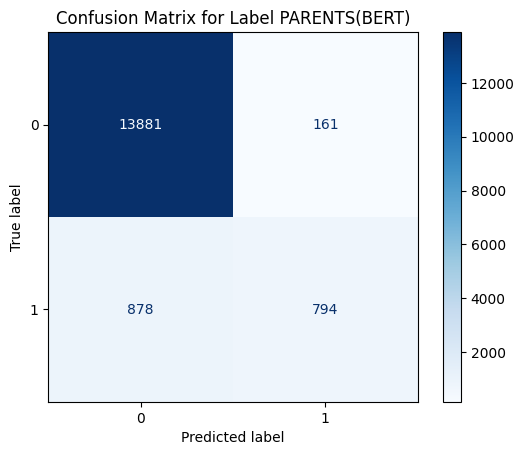

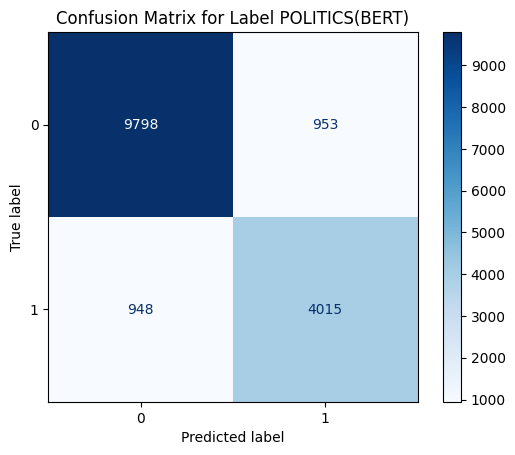

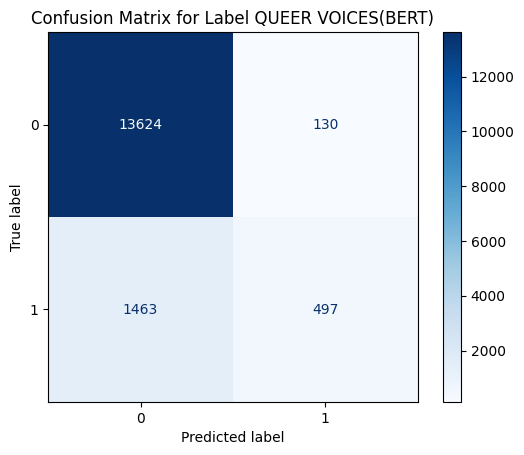

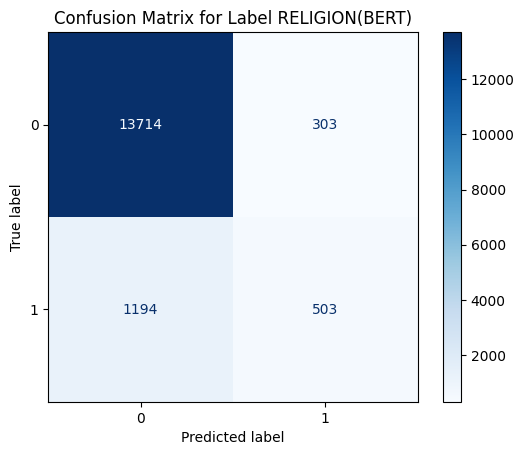

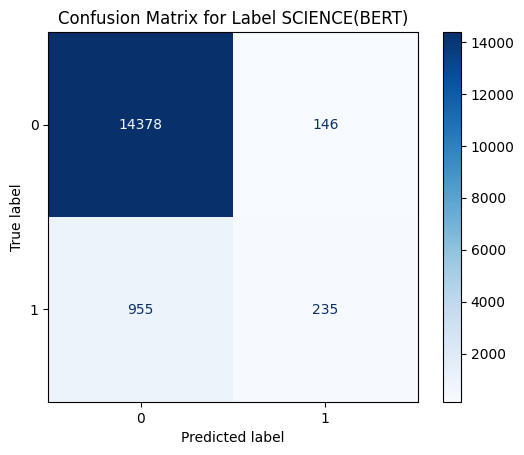

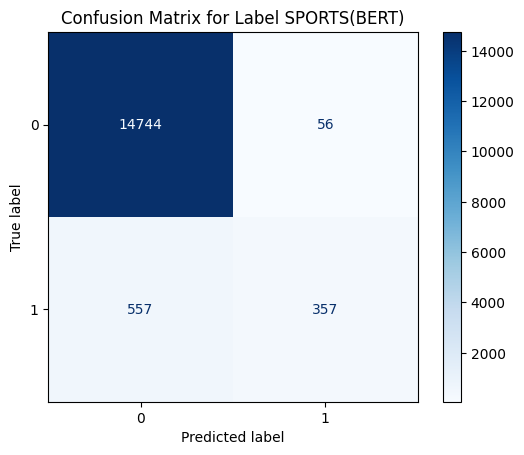

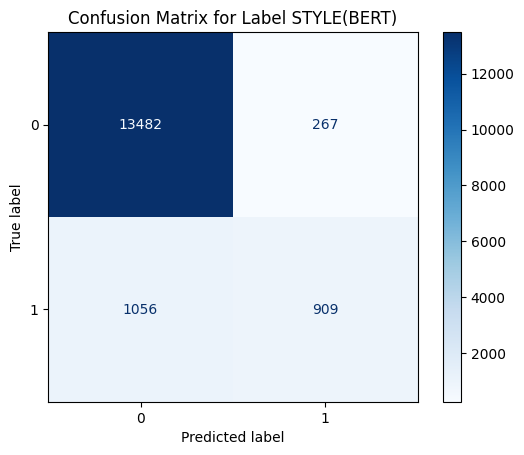

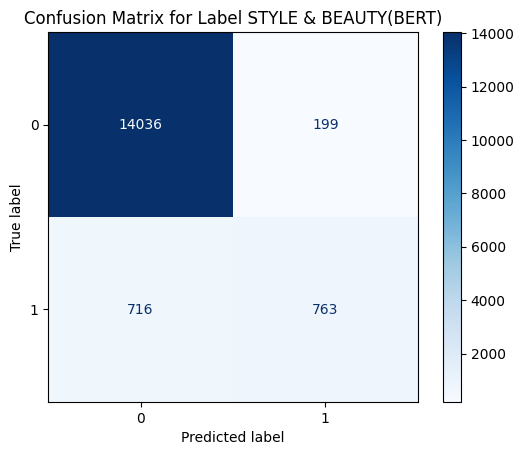

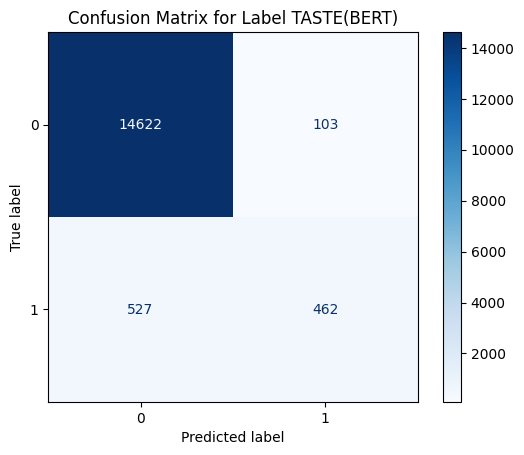

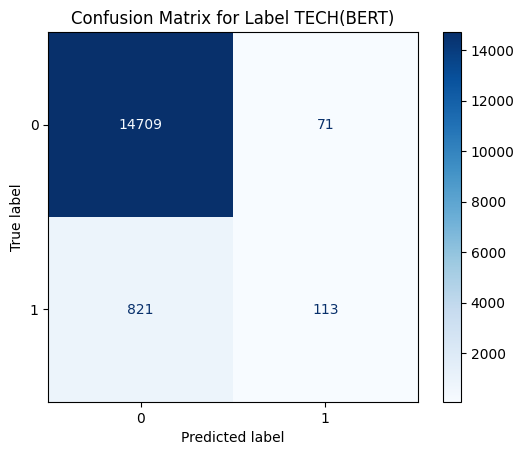

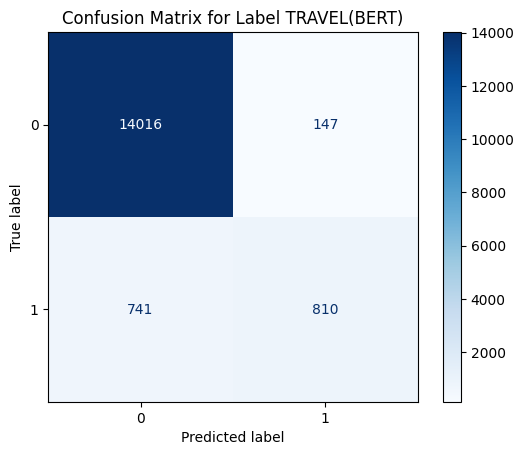

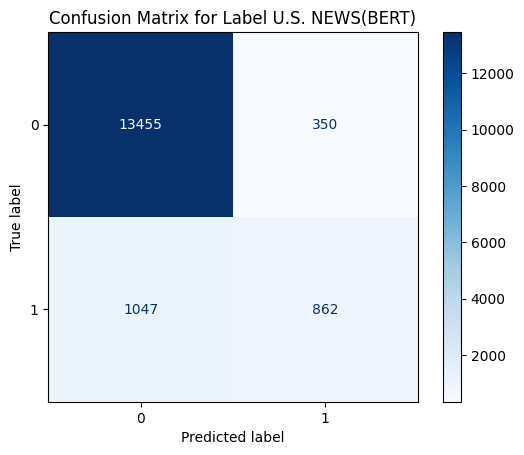

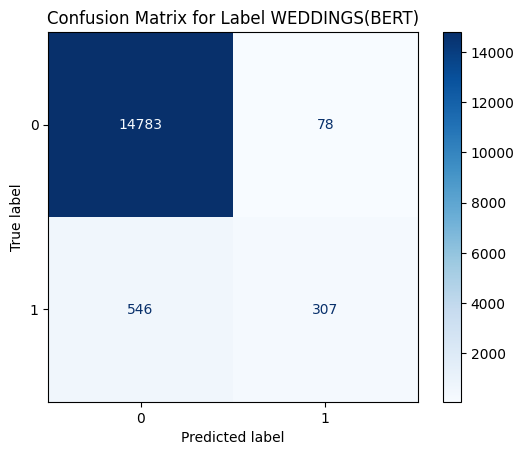

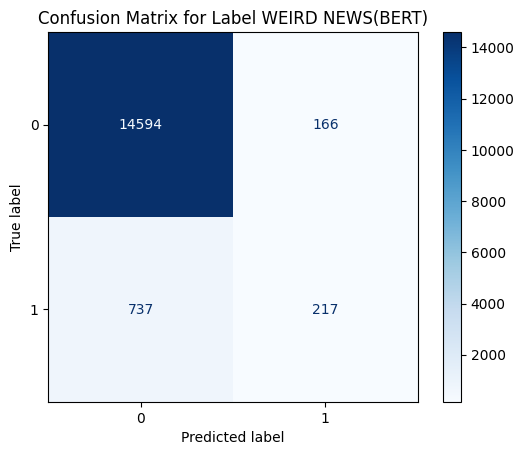

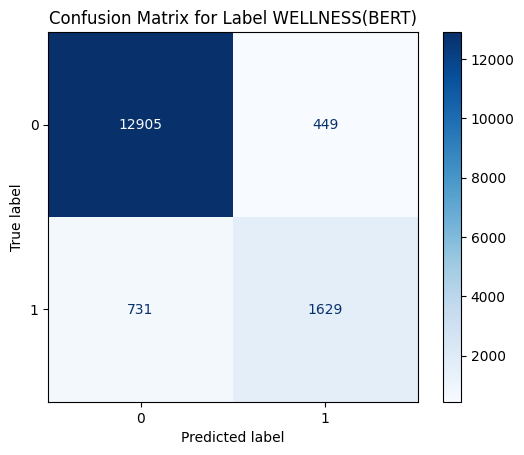

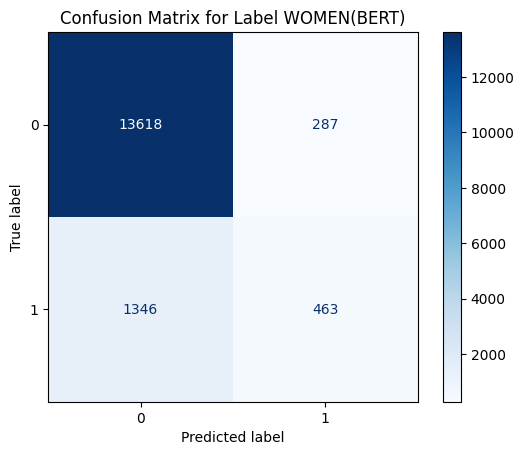

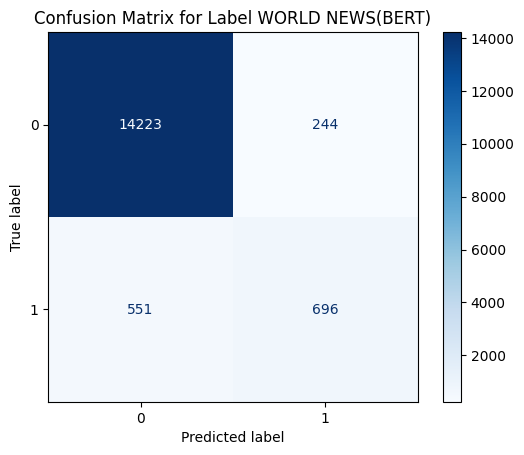

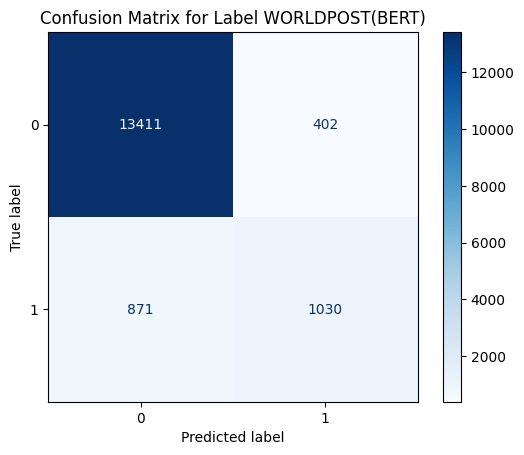

In [48]:
def plot_confusion_matrices(y_true, y_pred):
    num_labels = y_true.shape[1]
    for i in range(41):
        cm = confusion_matrix(y_true[:,:, i], y_pred[:,:, i])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for Label {category_list[i]}(BERT)')
        plt.savefig(f'AI-FInal-Project-main/fig/Label_{category_list[i]}(BERT).png')
all_true = np.array(all_true)
all_pred = np.array(all_pred)
plot_confusion_matrices(all_true, all_pred)